# Assignment (Week 8): Computation Graph

A computational graph is a directed graph where the nodes correspond to operations or variables. Variables can feed their value into operations, and operations can feed their output into other operations. This way, every node in the graph defines a function of the variables. The values that are fed into the nodes and come out of the nodes are called tensors, which is just a fancy word for a multi-dimensional array. Hence, it subsumes scalars, vectors and matrices as well as tensors of a higher rank.

# Operations

Every operation is characterized by three things:

1. A compute function that computes the operation's output given values for the operation's inputs
2. A list of input_nodes which can be variables or other operations
3. A list of consumers that use the operation's output as their input

In [1]:
class Operation:
    """Represents a graph node that performs a computation.

    An `Operation` is a node in a `Graph` that takes zero or
    more objects as input, and produces zero or more objects
    as output.
    """

    def __init__(self, input_nodes=[]):
        """Construct Operation
        """
        self.input_nodes = input_nodes

        # Initialize list of consumers (i.e. nodes that receive this operation's output as input)
        self.consumers = []

        # Append this operation to the list of consumers of all input nodes
        for input_node in input_nodes:
            input_node.consumers.append(self)

        # Append this operation to the list of operations in the currently active default graph
        _default_graph.operations.append(self)

    def compute(self):
        """Computes the output of this operation.
        "" Must be implemented by the particular operation.
        """
        pass

# Some elementary operations

1. Add
2. Multiply
3. Inverse
4. Max
5. Matrix Multiplication

# ADD Implementation

In [2]:
class add(Operation):
    """Returns x + y element-wise.
    """

    def __init__(self, x, y):
        """Construct add

        Args:
          x: First summand node
          y: Second summand node
        """
        super().__init__([x, y])

    def compute(self, x_value, y_value):
        """Compute the output of the add operation

        Args:
          x_value: First summand value
          y_value: Second summand value
        """
        return x_value + y_value

# Multiply Implementation

In [3]:
class mul(Operation):
    """Returns x + y element-wise.
    """

    def __init__(self, x, y):
        """Construct add

        Args:
          x: First summand node
          y: Second summand node
        """
        super().__init__([x, y])

    def compute(self, x_value, y_value):
        """Compute the output of the add operation

        Args:
          x_value: First summand value
          y_value: Second summand value
        """
        return x_value * y_value

# Inverse Implementaion

In [4]:
class inv(Operation):
    """Returns x + y element-wise.
    """

    def __init__(self, x):
        """Construct add

        Args:
          x: First summand node
          y: Second summand node
        """
        super().__init__([x])

    def compute(self, x_value):
        """Compute the output of the add operation

        Args:
          x_value: First summand value
          y_value: Second summand value
        """
        return (1/x_value)

# MAX Implementaion

In [5]:
class MAX(Operation):
    """Returns x + y element-wise.
    """

    def __init__(self, x, y):
        """Construct add

        Args:
          x: First summand node
          y: Second summand node
        """
        super().__init__([x, y])

    def compute(self, x_value, y_value):
        """Compute the output of the add operation

        Args:
          x_value: First summand value
          y_value: Second summand value
        """
        return max(x_value, y_value)

# Matrix Multiplication

In [6]:
class matmul(Operation):
    """Multiplies matrix a by matrix b, producing a * b.
    """

    def __init__(self, a, b):
        """Construct matmul

        Args:
          a: First matrix
          b: Second matrix
        """
        super().__init__([a, b])

    def compute(self, a_value, b_value):
        """Compute the output of the matmul operation

        Args:
          a_value: First matrix value
          b_value: Second matrix value
        """
        return a_value.dot(b_value)

# Placeholders

Not all the nodes in a computational graph are operations. For example, in the affine transformation graph, **A, x and b** are not operations. Rather, they are inputs to the graph that have to be supplied with a value once we want to compute the output of the graph. To provide such values, we introduce placeholders.

In [7]:
class placeholder:
    """Represents a placeholder node that has to be provided with a value
       when computing the output of a computational graph
    """

    def __init__(self):
        """Construct placeholder
        """
        self.consumers = []

        # Append this placeholder to the list of placeholders in the currently active default graph
        _default_graph.placeholders.append(self)

# Variables

In the affine transformation graph, there is a qualitative difference between x on the one hand and A and b on the other hand. While x is an input to the operation, A and b are parameters of the operation, i.e. they are intrinsic to the graph. We will refer to such parameters as Variables.

In [8]:
class Variable:
    """Represents a variable (i.e. an intrinsic, changeable parameter of a computational graph).
    """

    def __init__(self, initial_value=None):
        """Construct Variable

        Args:
          initial_value: The initial value of this variable
        """
        self.value = initial_value
        self.consumers = []

        # Append this variable to the list of variables in the currently active default graph
        _default_graph.variables.append(self)

# The Graph Class

Finally, we'll need a class that bundles all the operations, placeholders and variables together. When creating a new graph, we can call its as_default method to set the _default_graph to this graph. This way, we can create operations, placeholders and variables without having to pass in a reference to the graph everytime.

In [9]:
class Graph:
    """Represents a computational graph
    """

    def __init__(self):
        """Construct Graph"""
        self.operations = []
        self.placeholders = []
        self.variables = []

    def as_default(self):
        global _default_graph
        _default_graph = self

# Session

Now that we are confident creating computational graphs, we can start to think about how to compute the output of an operation.

Let's create a Session class that encapsulates an execution of an operation. We would like to be able to create a session instance and call a run method on this instance, passing the operation that we want to compute and a dictionary containing values for the placeholders:

This should compute the following value:

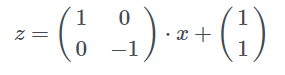

In order to compute the function represented by an operation, we need to apply the computations in the right order. For example, we cannot compute **z** before we have computed **y** as an intermediate result. Therefore, we have to make sure that the operations are carried out in the right order, such that the values of every node that is an input to an operation **o** has been computed before **o** is computed. This can be achieved via post-order traversal.

In [10]:
import numpy as np


class Session:
    """Represents a particular execution of a computational graph.
    """

    def run(self, operation, feed_dict={}):
        """Computes the output of an operation

        Args:
          operation: The operation whose output we'd like to compute.
          feed_dict: A dictionary that maps placeholders to values for this session
        """

        # Perform a post-order traversal of the graph to bring the nodes into the right order
        nodes_postorder = traverse_postorder(operation)

        # Iterate all nodes to determine their value
        for node in nodes_postorder:

            if type(node) == placeholder:
                # Set the node value to the placeholder value from feed_dict
                node.output = feed_dict[node]
            elif type(node) == Variable:
                # Set the node value to the variable's value attribute
                node.output = node.value
            else:  # Operation
                # Get the input values for this operation from the output values of the input nodes
                node.inputs = [input_node.output for input_node in node.input_nodes]

                # Compute the output of this operation
                node.output = node.compute(*node.inputs)

            # Convert lists to numpy arrays
            if type(node.output) == list:
                node.output = np.array(node.output)

        # Return the requested node value
        return operation.output


def traverse_postorder(operation):
    """Performs a post-order traversal, returning a list of nodes
    in the order in which they have to be computed

    Args:
       operation: The operation to start traversal at
    """

    nodes_postorder = []

    def recurse(node):
        if isinstance(node, Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append(node)

    recurse(operation)
    return nodes_postorder

# Example

Let's now use the classes we have built to create a computational graph for the following affine transformation:

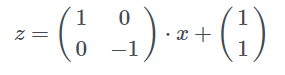

In [11]:
# Create a new graph
Graph().as_default()

# Create variables
A = Variable([[1, 0], [0, -1]])
b = Variable([1, 1])

# Create placeholder
x = placeholder()

# Create hidden node y
y = matmul(A, x)

# Create output node z
z = add(y, b)

In [12]:
session = Session()
output = session.run(z, {
    x: [1, 2]
})
print(output)

[ 2 -1]
